<a href="https://colab.research.google.com/github/dpriyabijosh/DeepLearning/blob/main/BiLSTM_Word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A - Introduction

## 1. Load Essential Libraries

In [ ]:
%%time
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
!pip install nltk
import nltk
from sklearn.model_selection import train_test_split
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional,Flatten, Dropout
from sklearn.model_selection import train_test_split
import pickle


%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
CPU times: user 57.9 ms, sys: 33.6 ms, total: 91.5 ms
Wall time: 5.97 s


## 2. Dataset

### 2.1. Download Dataset

### 2.2. Load Train Data
The DepressionDetection_preprocessing notebook contains data load function. We will be importing the data from the DepressionDetection_preprocessing notebook.

In [ ]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')
path="/content/drive/My Drive/Colab Notebooks"
os.chdir(path)

Mounted at /content/drive


In [ ]:
!pip install import-ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import import_ipynb

In [ ]:
# Import from pre-processing notebook
from DepressionDetection_preprocessing import initail_dataload, clean_empty_rows, clean_tweet

In [ ]:
#Loading dataset
df_n = initail_dataload()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Transform and clean the dataset

#Rename the columns
df_n.rename(columns={'raw_tweet' :'tweet'},inplace=True)

# Perform Cleaning and Lemmatization
df_n['tweet'] = df_n['tweet'].apply(clean_tweet)

In [ ]:
 # Removing empty rows
data = clean_empty_rows(df_n,'tweet')

Initial size (10314, 2)
Shape after cleaning (10278, 2)


##Splitting the Data

In [ ]:
X_data, y_data = np.array(df_n['tweet']), np.array(df_n['label'])
label = df_n.label.values
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = 0.20, random_state = 40, stratify = label)
print('Data Split done.')

Data Split done.


Word Embedding
## <a id="5">Creating Word Embeddings using Word2Vec model</a>

**Word embedding** is one of the most popular representation of document vocabulary. It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc. Word embeddings are **vector representations** of a particular word.

Word2Vec can create word embeddings using two methods (both involving Neural Networks): **Skip Gram** and **Common Bag Of Words (CBOW)**

In [ ]:
from gensim.models import Word2Vec

Embedding_dimensions = 100

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

**Word2Vec()** function creates and trains the word embeddings using the data passed.

**Training Parameters**
* **size:** The number of dimensions (N) that the Word2Vec maps the words onto. Bigger size values require more training data, but can lead to better (more accurate) models.
* **workers:** Specifies the number of worker threads for training parallelization, to speed up training.
* **min_count:** min_count is for pruning the internal dictionary. Words that appear only once or twice in a billion-word corpus are probably uninteresting typos and garbage. In addition, there’s not enough data to make any meaningful training on those words, so it’s best to ignore them.

In [ ]:
%%time

# Defining the model and training it.
word2vec_model = Word2Vec(Word2vec_train_data,
                 size=Embedding_dimensions,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.index2word))

Vocabulary Length: 1975
CPU times: user 1.09 s, sys: 50 ms, total: 1.14 s
Wall time: 886 ms


## <a id="7">Tokenizing and Padding datasets</a>

**Tokenization** is a common task in **Natural Language Processing (NLP)**. It’s a fundamental step in both traditional NLP methods like **Count Vectorizer** and Advanced Deep Learning-based architectures like **Transformers**.

**Tokenization** is a way of separating a piece of text into smaller units called **tokens**. Here, tokens can be either words, characters, or subwords. Hence, tokenization can be broadly classified into 3 types – word, character, and subword (n-gram characters) tokenization.

All the neural networks require to have inputs that have the same shape and size. However, when we pre-process and use the texts as inputs for our model e.g. LSTM, not all the sentences have the same length. We need to have the inputs with the same size, this is where the **padding** is necessary.

**Padding** is the process by which we can add padding tokens at the start or end of a sentence to increase it's length upto the required size. If required, we can also drop some words to reduce to the specified length.


* **Tokenizer:** Tokenizes the dataset into a list of tokens.
* **pad_sequences:** Pads the tokenized data to a certain length.

The **input_length** has been set to 60. This will be the length after the data is tokenized and padded.

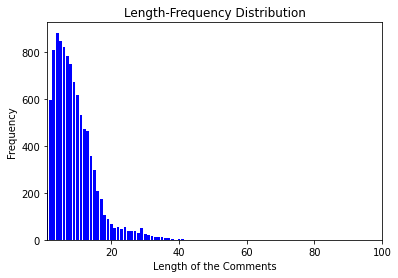

Maximum Length of a Comment: 51
Minimum Length of a Comment: 0
Average Length of a Comment: 9.0


In [ ]:
#Checking the input length
df_n['tweet_length'] = df_n.tweet.apply(lambda x:len(x.split()))
frequency = dict()
for i in df_n.tweet_length:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="b")
plt.xlim(1, 100)
# in this notbook color is not working but it should work.
plt.xlabel('Length of the Comments')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()
max_lenth = max(df_n.tweet_length)
print(f"Maximum Length of a Comment: {max_lenth}")
print(f"Minimum Length of a Comment: {min(df_n.tweet_length)}")
print(f"Average Length of a Comment: {round(np.mean(df_n.tweet_length),0)}")

In [ ]:
# Defining the model input length.
#input_length = 60
input_length = max_lenth

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Defining the Tokenizer and fitting it on the training data. Here, we are tokenzing the data by spliting it up with the delimiter space ' '.

Args in Tokenizer():

filters: Characters to filter out from the sentences to tokenize.
lower: True/False. Whether to lowerCase the sentence or not.
oov_token: Out of Vocabulary token to put in for words which aren't in the tokenizer vocab.
Filters and lower has been turned off because we've already done those steps during the preprocessing step.

In [ ]:
vocab_length = 60000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 60000


Tokenizing the X_train and X_test dataset and padding them to the length 'input_length'.

The tokenized list is pre-padded, i.e padding tokens are added to the start. After padding, the length of the data would be equal to 'input_length'.

In [ ]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (8251, 51)
X_test.shape : (2063, 51)


In [ ]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (60000, 100)


Creating the Model¶

There are different approches which we can use to build our Sentiment analysis model. We're going to build a deeplearning Sequence model.

Sequence model are very good at getting the context of a sentence, since it can understand the meaning rather than employ techniques like counting positive or negative words like in a Bag-of-Words model.

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding

### Model Architecture

1) **Embedding Layer:** Layer responsible for converting the tokens into their vector representation that is generated by Word2Vec model. We're using the predefined layer from Tensorflow in out model.

**Arguments -**
* **input_dim**: Size of the vocabulary.
* **output_dim**: Dimension of the dense embedding.
* **weights**: Initiazises the embedding matrix.
* **trainable**: Specifies whether the layer is trainable or not.

2) **Bidirectional:** Bidirectional wrapper for RNNs. It means the context are carried from both left to right and right to left in the wrapped RNN layer.

3) **LSTM:** **Long Short Term Memory**, its a variant of **RNN** which has memory state cell to learn the context of words which are at further along the text to carry contextual meaning rather than just neighbouring words as in case of RNN. 

**Arguments -**
* **units:** Positive integer, dimensionality of the output space.
* **dropout:**  Fraction of the units to drop for the linear transformation of the inputs.
* **return_sequence:** Whether to return the last output in the output sequence, or the full sequence.

4) **Conv1D:** This layer creates a convolution kernel that is convolved with the layer input over a single dimension to produce a tensor of outputs.

**Arguments -**
* **filters:** The dimensionality of the output space (i.e. the number of output filters in the convolution).
* **kernel_size:** Specifies the length of the 1D convolution window.
* **activation:** Specifies the activation function to use. 

5) **GlobalMaxPool1D:** Downsamples the input representation by taking the maximum value over the different dimensions.


6) **Dense:** Dense layer adds a fully connected layer in the model. The argument passed specifies the number of nodes in that layer.

The last dense layer has the activation **"Sigmoid"**, which is used to transform the input to a number between 0 and 1. Sigmoid activations are generally used when we have 2 categories to output in.

In [ ]:
def getModel():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")
    return model

In [ ]:
training_model = getModel()
training_model.summary()

Model: "Sentiment_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 51, 100)           6000000   
                                                                 
 bidirectional (Bidirectiona  (None, 51, 200)          160800    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 51, 200)          240800    
 nal)                                                            
                                                                 
 conv1d (Conv1D)             (None, 47, 100)           100100    
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                   

##Training the Model



Model Callbacks

Callbacks are objects that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc).

We can use callbacks to write TensorBoard logs after every batch of training, periodically save our model, stop training early or even to get a view on internal states and statistics during training.

ReduceLROnPlateau: Reduces Learning Rate whenever the gain in performance metric specified stops improving.

monitor: quantity to be monitored.
patience: number of epochs with no improvement after which learning rate will be reduced.
cooldown: number of epochs to wait before resuming normal operation after lr has been reduced.
EarlyStopping: Stop training when a monitored metric has stopped improving.

monitor: Quantity to be monitored.
min_delta: Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
patience: Number of epochs with no improvement after which training will be stopped.
For more details on callbacks, check out the documentation on tensorflow.

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

Model Compile

The Model must be compiled to define the loss, metrics and optimizer. Defining the proper loss and metric is essential while training the model.

Loss: We're using Binary Crossentropy. It is used when we have binary output categories. Check out this article on losses.

Metric: We've selected Accuracy as it is one of the common evaluation metrics in classification problems when the category data is equal. Learn more about metrics here.

Optimizer: We're using Adam, optimization algorithm for Gradient Descent. You can learn more about Adam here.

In [ ]:
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

We'll now train our model using the **fit** method and store the output learning parameters in **history**, which can be used to plot out the learning curve.

**Arguements:**
* **batch_size:** Number of samples per gradient update. Increasing the batch_size speeds up the training.
* **epochs:** Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided.
* **validation_split:** Float between 0 and 1. Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch
* **callbacks:** List of callbacks to apply during training process.
* **verbose:** 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.

In [ ]:
history = training_model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=12,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/12
8/8 [==============================] - 18s 388ms/step - loss: 0.6124 - accuracy: 0.7694 - val_loss: 0.5350 - val_accuracy: 0.7893 - lr: 0.0010
Epoch 2/12
8/8 [==============================] - 1s 95ms/step - loss: 0.5172 - accuracy: 0.7865 - val_loss: 0.4735 - val_accuracy: 0.7942 - lr: 0.0010
Epoch 3/12
8/8 [==============================] - 1s 101ms/step - loss: 0.4904 - accuracy: 0.7960 - val_loss: 0.4543 - val_accuracy: 0.8208 - lr: 0.0010
Epoch 4/12
8/8 [==============================] - 1s 100ms/step - loss: 0.4653 - accuracy: 0.8214 - val_loss: 0.4409 - val_accuracy: 0.8257 - lr: 0.0010
Epoch 5/12
8/8 [==============================] - 1s 95ms/step - loss: 0.4565 - accuracy: 0.8189 - val_loss: 0.4250 - val_accuracy: 0.8293 - lr: 0.0010
Epoch 6/12
8/8 [==============================] - 1s 96ms/step - loss: 0.4540 - accuracy: 0.8189 - val_loss: 0.4125 - val_accuracy: 0.8487 - lr: 0.0010
Epoch 7/12
8/8 [==============================] - 1s 95ms/step - loss: 0.4521 - accu

Evaluating Model

Since our dataset is not skewed, i.e. it has equal number of Positive and Negative Predictions. We're choosing Accuracy as our evaluation metric. Furthermore, we're plotting the Confusion Matrix to get an understanding of how our model is performing on both classification types.

Printing out the Learning curve

Learning curves show the relationship between training set size and your chosen evaluation metric (e.g. RMSE, accuracy, etc.) on your training and validation sets. They can be an extremely useful tool when diagnosing your model performance, as they can tell you whether your model is suffering from bias or variance.

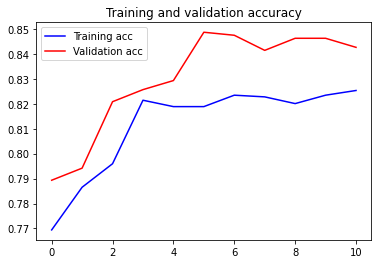

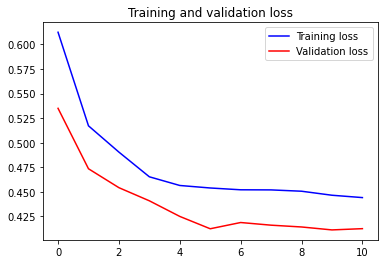

In [ ]:
acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

From the training curve we can conclude that our model doesn't have bias nor is it overfitting. The accuracy curve has flattened but is still rising, which means training for more epochs can yield better results.

The Validation loss is lower than the training loss because the dropouts in LSTM aren't active while evaluating the model.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def ConfusionMatrix(y_pred, y_test):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

65/65 [==============================] - 2s 8ms/step


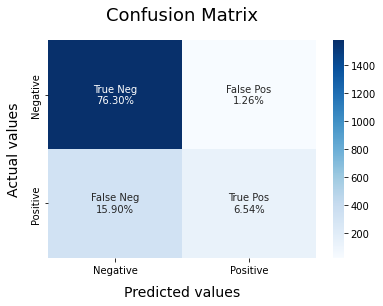

In [ ]:
# Predicting on the Test dataset.
y_pred = training_model.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

# Printing out the Evaluation metrics. 
ConfusionMatrix(y_pred, y_test)

From the confusion matrix, it can be concluded that the model makes more False Negative predictions than positive. This means that the model is somewhat biased towards predicting negative sentiment.

### Classification Report

In [ ]:
# Print the evaluation metrics for the dataset.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.98      0.90      1600
           1       0.84      0.29      0.43       463

    accuracy                           0.83      2063
   macro avg       0.83      0.64      0.67      2063
weighted avg       0.83      0.83      0.79      2063



Using the classification report, we can see that that the model achieves nearly **93% Accuracy** after training for just **12 epochs.** 

## <a id="12">Saving the Model</a>

We're saving the **tokenizer, Word2Vec and Tensorflow model** for use later.

**Word2Vec model** has been saved as 2 different formats:
1. **KeyedVectors:** KeyedVectors do not support further training. On the other hand, by shedding the internal data structures necessary for training, KeyedVectors offer a smaller RAM footprint and a simpler interface.
2. **Full Word2Vec Model:** The Full Word2Vec model contains the model state to enable further training. Saving in this format enables us to update the Vectors later.

In [ ]:
# Saving Word2Vec-Model
word2vec_model.wv.save('Word2Vec-twitter-100')
word2vec_model.wv.save_word2vec_format('Word2Vec-twitter-100-trainable')

# Saving the tokenizer
with open('Tokenizer.pickle', 'wb') as file:
    pickle.dump(tokenizer, file)

# Saving the TF-Model.
training_model.save('Sentiment-BiLSTM')
training_model.save_weights("Model Weights/weights")